In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv', encoding='latin-1')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# base cleaning function: remove mentions, hashtags, digits, etc

def clean(text):
    # print(text)
    text = text.lower()
    text = re.sub(r'http\S+', " ", text)
    text = re.sub(r'@\w+',' ',text)
    text = re.sub(r'#\w+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # text = re.sub(r'<.*?>',' ', text)
    text = text.replace(r'\\r', ' ')
    text = text.replace(r'\\n', ' ')
    # print(text, end='\n -----------')
    return text

In [4]:
text = df['review']
y = pd.factorize(df['sentiment'])[0]

In [5]:
text = text.apply(clean)

In [19]:
text

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(text, y)
text

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. <br /><br />the...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

In [8]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [9]:
VOCAB_SIZE = 15000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(x_train.values)

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:50]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'be', 'he',
       'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so',
       'like', 'or', 'just', 'her', 'about', 'if', 'has', 'out', 'some',
       'there', 'what'], dtype='<U17')

In [11]:
x_train[:6]

39198    the skeleton of the story is that the main cha...
38701    my girls   and   love this show. we stumbled a...
46086    <br /><br />very dull, laborious adaptation of...
12262    it probably isn't fair that i have got to see ...
49351    an excellent example of what happens when one ...
18493    gung ho is one of those movies that i never ge...
Name: review, dtype: object

In [23]:
encoded_example = encoder(x_train[7])[:3].numpy()
encoded_example

array([ 11, 119,  14])

In [20]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, )),
    tf.keras.layers.Dense(64, activation='relu'),

    #Output layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [22]:
history = model.fit(x_train, y=y_train, 
                    validation_data=(x_valid, y_valid),
                    epochs=10)

Epoch 1/10
1172/1172 [==============================] - 197s 153ms/step - loss: 0.5282 - accuracy: 0.6966 - val_loss: 0.2721 - val_accuracy: 0.8875
Epoch 2/10
1172/1172 [==============================] - 175s 149ms/step - loss: 0.2073 - accuracy: 0.9212 - val_loss: 0.2777 - val_accuracy: 0.8858
Epoch 3/10
1172/1172 [==============================] - 173s 147ms/step - loss: 0.1559 - accuracy: 0.9448 - val_loss: 0.2932 - val_accuracy: 0.8890
Epoch 4/10
1172/1172 [==============================] - 173s 148ms/step - loss: 0.1125 - accuracy: 0.9616 - val_loss: 0.3109 - val_accuracy: 0.8856
Epoch 5/10
1172/1172 [==============================] - 174s 149ms/step - loss: 0.0881 - accuracy: 0.9714 - val_loss: 0.3694 - val_accuracy: 0.8834
Epoch 6/10
1172/1172 [==============================] - 174s 148ms/step - loss: 0.0671 - accuracy: 0.9795 - val_loss: 0.4723 - val_accuracy: 0.8694
Epoch 7/10
1172/1172 [==============================] - 174s 148ms/step - loss: 0.0493 - accuracy: 0.9854 - val_

In [35]:
preds = model.predict(x_valid)

In [36]:
test_loss, test_acc = model.evaluate(x_valid, y_valid)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 29s 54ms/step - loss: 3.9937 - accuracy: 0.5072
Test Loss: 3.9851369857788086
Test Accuracy: 0.5062400102615356


(0.0, 0.5970052815042436)

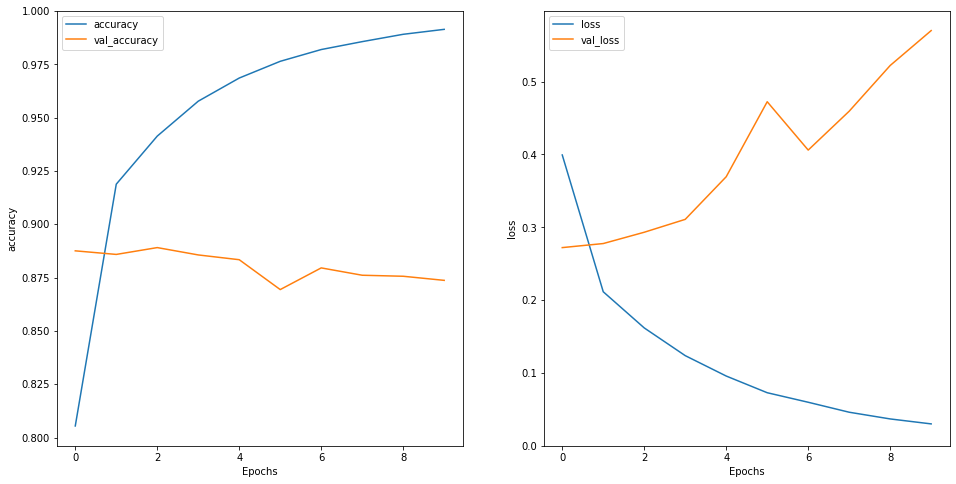

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [29]:
sample_text = ('The movie was cool boring')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.75728714]], dtype=float32)

In [60]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 32, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [47]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [48]:
history = model.fit(x_train,
                    y_train, 
                    validation_data=(x_valid, y_valid),
                    epochs=10,
                    validation_steps=30)

Epoch 1/10
1172/1172 [==============================] - 141s 108ms/step - loss: 0.6931 - accuracy: 0.5009 - val_loss: 0.6928 - val_accuracy: 0.5062
Epoch 2/10
1172/1172 [==============================] - 122s 104ms/step - loss: 0.6924 - accuracy: 0.4977 - val_loss: 0.6908 - val_accuracy: 0.5062
Epoch 3/10
1172/1172 [==============================] - 124s 105ms/step - loss: 0.6859 - accuracy: 0.4984 - val_loss: 0.5770 - val_accuracy: 0.7279
Epoch 4/10
1172/1172 [==============================] - 123s 105ms/step - loss: 0.5547 - accuracy: 0.7144 - val_loss: 0.4723 - val_accuracy: 0.7842
Epoch 5/10
1172/1172 [==============================] - 125s 107ms/step - loss: 0.4710 - accuracy: 0.7825 - val_loss: 0.4262 - val_accuracy: 0.8103
Epoch 6/10
1172/1172 [==============================] - 124s 106ms/step - loss: 0.4292 - accuracy: 0.8130 - val_loss: 0.3922 - val_accuracy: 0.8305
Epoch 7/10
1172/1172 [==============================] - 124s 106ms/step - loss: 0.3922 - accuracy: 0.8348 - val_

In [50]:
test_loss, test_acc = model.evaluate(x_valid, y_valid)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 46ms/step - loss: 0.3206 - accuracy: 0.8678
Test Loss: 0.3206188380718231
Test Accuracy: 0.8677600026130676


In [68]:
# predict on a sample text without padding.

sample_text = ('its a bullshit ')
predictions = model.predict(np.array([sample_text]))
print(predictions)


[[0.4994557]]


In [57]:
l = model.layers[-1]

<function tensorflow.python.keras.activations.linear>